In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf

## Step 1: Data Cleaning

In [3]:
df = pd.read_csv('wl_ts_data.csv')

# Set 'time_met' as the index
df['time_met'] = pd.to_datetime(df['time_met'])
df.set_index('time_met', inplace=True)

# Drop columns
df = df[['wl_obs']]

# Drop rows
start_date = pd.to_datetime('2023-04-01 04:00:00')
end_date = pd.to_datetime('2024-04-30 04:00:00')
df = df[(df.index > start_date) & (df.index < end_date)]

## Step 2: Train-Test Split

In [5]:
df_train = df[df.index < pd.to_datetime('2024-04-01 04:00:00')]
df_test = df[df.index >= pd.to_datetime('2024-04-01 04:00:00')]

## Step 3: Feature Engineering

### Data normalization

Since the spike prediction is important, the min-max normalization is selected based on the distribution of wl_obs.

In [7]:
scaler = MinMaxScaler()

df_train = df_train.copy()
df_test = df_test.copy()

df_train.loc[:,'wl_scaled'] = scaler.fit_transform(df_train[['wl_obs']])
df_test.loc[:,'wl_scaled'] = scaler.transform(df_test[['wl_obs']])

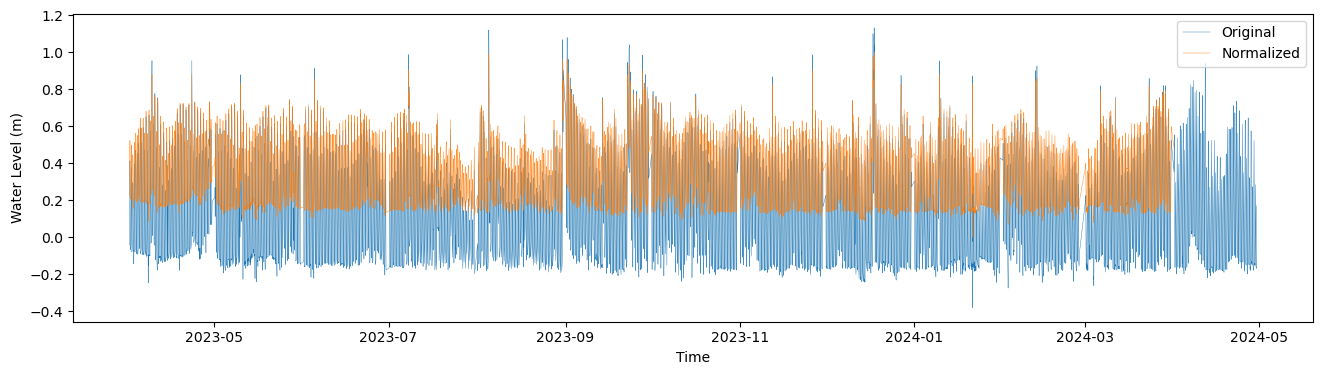

In [9]:
plt.figure(figsize=(16, 4))
plt.plot(df['wl_obs'], linewidth=0.3, label='Original')
plt.plot(df_train['wl_scaled'], linewidth=0.3, label='Normalized')
plt.xlabel('Time')
plt.ylabel('Water Level (m)')
plt.legend()
plt.show()

### Decomposition of time series

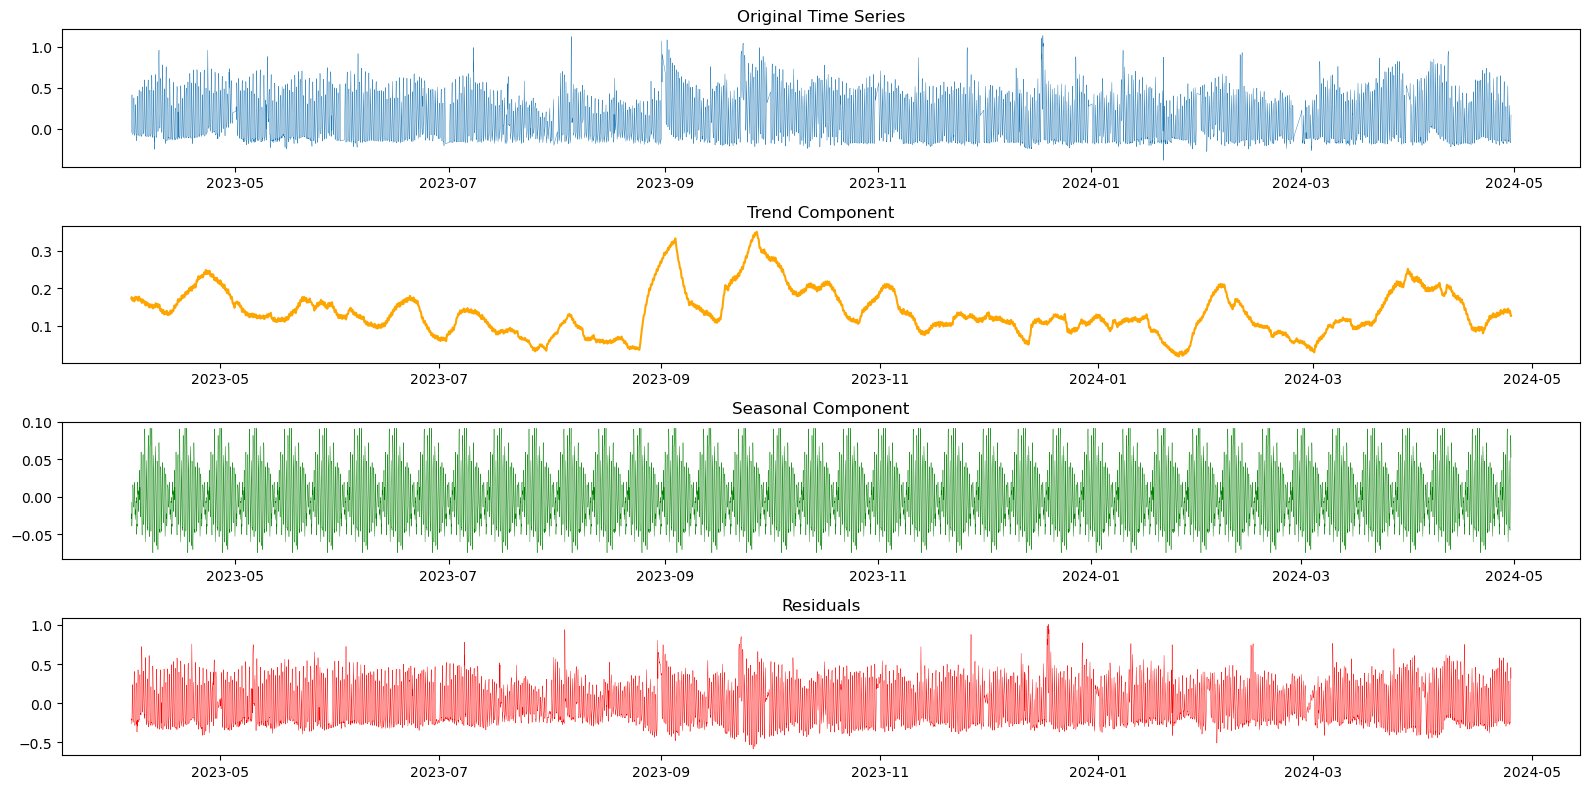

In [11]:
# Adjust the period parameter
decomposition = seasonal_decompose(df['wl_obs'], model='additive', period=24*10)

plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(df['wl_obs'], linewidth=0.3)
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(decomposition.trend, color='orange')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(decomposition.seasonal, linewidth=0.3, color='green')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(decomposition.resid, linewidth=0.3, color='red')
plt.title('Residuals')

plt.tight_layout()
plt.show()

### ACF/PACF

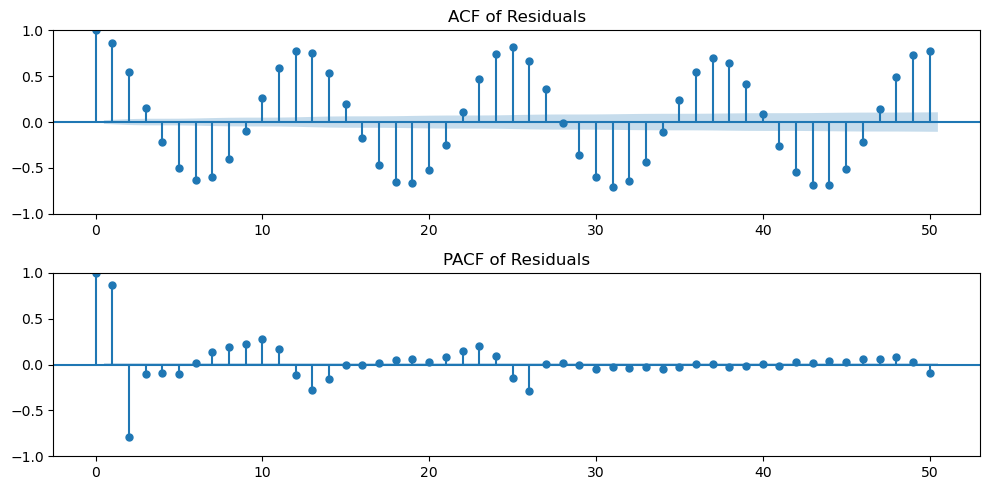

In [13]:
# Plot ACF and PACF for residuals
plt.figure(figsize=(10, 5))
plt.subplot(211)
plot_acf(decomposition.resid.dropna(), lags=50, ax=plt.gca())
plt.title('ACF of Residuals')

plt.subplot(212)
plot_pacf(decomposition.resid.dropna(), lags=50, ax=plt.gca())
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()

## Step 4: Model Selection & Implementation

### LSTM

In [15]:
# X - Features (water level in previous hours)
# y - Target (water level in the next hour)
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data.iloc[i:i+look_back])
        y.append(data.iloc[i+look_back])
    return np.array(X), np.array(y)

# Use the past 10 days (240 hours) to predict the water level in the next hour
look_back = 240
X, y = create_dataset(df_train['wl_scaled'], look_back)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Get the index for y_val
y_val_index = df_train.index[look_back+len(X_train) : look_back+len(X_train)+len(y_val)]

In [17]:
# Reshape data for the model (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Build the Neural Network Model using TensorFlow/Keras
lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), dropout=0.2),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])

lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [21]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[es])
y_pred = lstm.predict(X_val)

# Rescale the predictions and actual values to original range
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))

Epoch 1/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.1975 - val_loss: 0.0564
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 78141.7188 - val_loss: 0.0345
Epoch 3/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 258395.7031 - val_loss: 0.0330
Epoch 4/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0358 - val_loss: 0.0319
Epoch 5/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 57370066944.0000 - val_loss: 0.0348
Epoch 6/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 0.0386 - val_loss: 0.0348
Epoch 7/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0383 - val_loss: 0.0347
Epoch 8/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 0.0375 - val_loss: 0.0347
Epoch 9/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0376 - val_loss: 0.0347
Epoch 10/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0376 - val_loss: 0.0347
Epoch 11/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 0.0385 - val_loss: 0.0347
Ep

### Plot the training & validation loss over epochs

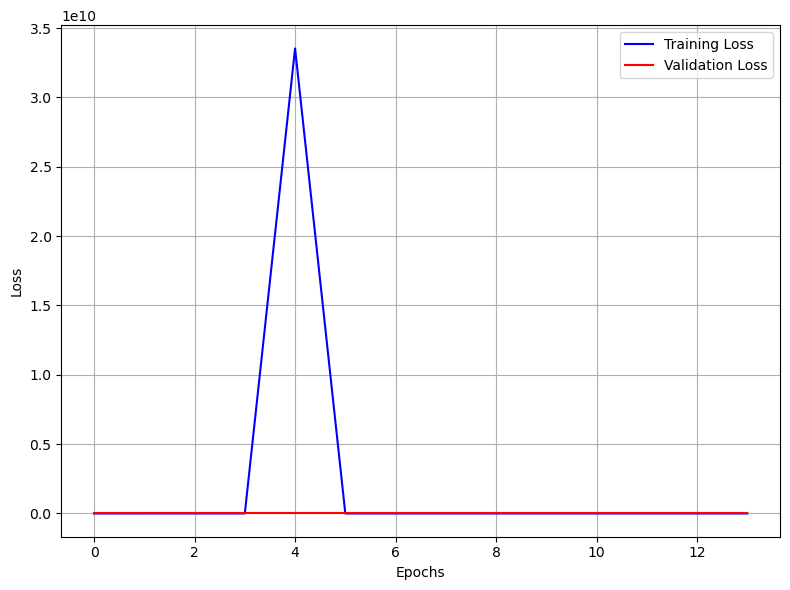

In [29]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Model evaluation with the test set

In [32]:
X_test, y_test = create_dataset(df_test['wl_scaled'], look_back)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
pred = lstm.predict(X_test)

# Rescale the predictions to original range
pred_rescaled = scaler.inverse_transform(pred)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


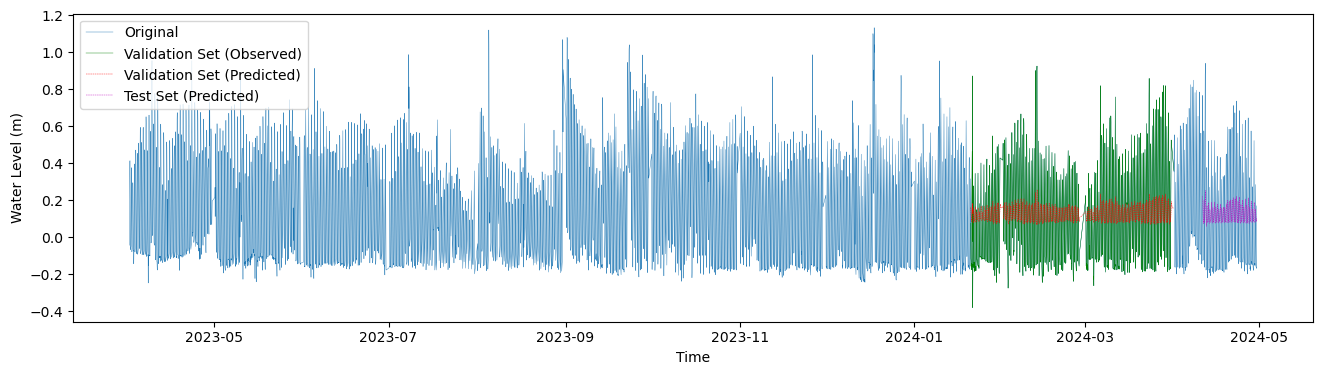

In [36]:
plt.figure(figsize=(16, 4))

# Plot the original time series
plt.plot(df['wl_obs'], linewidth=0.3, label='Original')

# Plot the predictions and actual values in the validation set
plt.plot(y_val_index, y_val_rescaled, label='Validation Set (Observed)', color='green', linewidth=0.3)
plt.plot(y_val_index, y_pred_rescaled, label='Validation Set (Predicted)', color='red', linestyle='--', linewidth=0.3)

# Plot the predictions in the test set
plt.plot(df_test.index[look_back:], pred_rescaled, label='Test Set (Predicted)', color='m', linestyle='--', linewidth=0.3)

plt.xlabel('Time')
plt.ylabel('Water Level (m)')
plt.legend()
plt.show()